In [524]:
import fermat as F
import numpy as np
import scipy.sparse as sp
import time
from scipy.spatial import  distance_matrix
from sklearn.manifold import TSNE
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from scipy.optimize import LinearConstraint
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist,cdist, squareform
import scipy


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

importe lo necesario y armo las funciones que me dicen el costo de transportar una serie de puntos con fermat dada la matriz de distancias de fermat (lo que usaba en transporte optimo antes), tambien hago su gradiente y pruebo

In [525]:
#Builds fermat graph given data, alpha, method (and if 'D' is chosen with k_fermat neighbours)
#RETURNS: fermat distance matrix between points of data and a KD-Tree 


def fermat_graph(data,alpha,method='FW',k_fermat=30):
    model=F.Fermat(alpha, path_method=method,k=k_fermat)
    model.fit(np.matrix(distance_matrix(data,data)))
    fermat_distances = model.get_distances()
    tree = KDTree(data, leaf_size=2)
    return fermat_distances,tree
              

#Computes fermat_cost of transporting initialData to x with the given fermat_distances
#initial data will be points

#It uses the KD-Tree built with fermat_graph() as well as a parameter 'k' which is 
#the amount of neighbours to look at when getting the fermat distance for a point that
#is not in the graph (including it may be computationally expensive)
#It also recieves the original data and the alpha used to build fermat_distances
              
#RETURNS: fermat cost and gradient of that cost
def fermat_cost_cuad(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)*2*dist
        res+=dist**2              
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient
#TODO ojoo cambie para la DISTANCIA AL CUADRADO!! 



#RETURNS: fermat cost and gradient of that cost
def fermat_cost(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)
        res+=dist              
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient



#Computes fermat distance between start  and end using fermat_distances
              
#it also recieves the KD-tree, numbre of neighbours to look at, and alpha used in fermat
              
#RETURNS: fermat distance between start and end, as well as the index of the k-nearest neighbour
#of end with smallest fermat distance to start
def fermat_dist(start,end,fermat_distances,tree,k,alpha):
    
    start_euclid_dist,start_ind=tree.query([start],k=1)
    idx=start_ind[0,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query([end],k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
        
    dist=min([ fermat_distances[idx,end_ind[0,i]]+end_euclid_dist[0,i] for i in range(end_euclid_dist.shape[1])])
    
    minim=np.argmin([ fermat_distances[idx,end_ind[0,i]] for i in range(end_ind.shape[1])]) 
    grad_idx=end_ind[0,minim] #index of k-nearest neighbour with smallest fermat_distance to idx.
    
    return dist+start_euclid_dist[0,0],grad_idx
              

#Here initialData are the points, and x the trasnportation of those
##UNUSED
def euclidean_cost(x,initialData):
    dim=initialData.shape[1]
    assert(initialData.shape[0]*dim==len(x))
    real_x=x.reshape(-1,dim)
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        res+=np.linalg.norm(initialData[i,:]-real_x[i,:])**2
        local_gradient=2*(real_x[i,:]-initialData[i,:])
        gradient[dim*i:(i+1)*dim]=local_gradient
    return res,gradient


Un fermat que paralieliza, sino es una tortuga

In [526]:
           
#RETURNS: fermat cost and gradient of that cost
def fermat_cost_cuad_fast(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    
    start_euclid_dist,start_ind=tree.query(initialData,k=1)
    idx=start_ind[:,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query(real_x,k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
    
    dist=([ [fermat_distances[idx[j],end_ind[j,i]]+end_euclid_dist[j,i] for i in range(end_euclid_dist.shape[1])] for j in range(end_euclid_dist.shape[0])])
    dist=np.array(dist)
    dist=np.min(dist,axis=1)
    
    minim=[[ fermat_distances[idx[j],end_ind[j,i]] for i in range(end_ind.shape[1])] for j in range(end_ind.shape[0])]  
    minim=np.argmin(minim,axis=1)
    
    grad_idx=[end_ind[j,minim[j]] for j in range(end_ind.shape[0])]
        
    distances=dist+start_euclid_dist[:,0]
    distances=distances.reshape(-1,1)
    
              
    q=data[grad_idx,:] 
    aux=alpha*(np.linalg.norm(q-real_x,axis=1)**(alpha-2)).reshape(-1,1)
    local_grad=aux*(real_x-q)*2*distances
    gradient=local_grad.flatten()
    res=np.linalg.norm(distances)**2   
    return res,gradient

Probamos que ande rapido

In [527]:
xx=np.random.random(samples.shape).flatten()

In [528]:
%%time
p,o=fermat_cost_cuad(xx,samples,dimension,f_dist,tree,data,k,alpha)

CPU times: user 212 ms, sys: 4 ms, total: 216 ms
Wall time: 216 ms


In [529]:
%%time
pp,oo=fermat_cost_cuad_fast(xx,samples,dimension,f_dist,tree,data,k,alpha)

CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 28.7 ms


In [530]:
print(np.abs(pp-p)<1e-15,np.alltrue(oo-o<1e-15))

True True


Creo funciones del algoritmo propuesto por Tabak, Zhao, Triglia

In [531]:
#ARMO LA MATRIZ C    

#vector con los valores z que hay, una matriz por filas paso
#viene en el mismo orden que los y
def armar_C(z,b=1):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=kernel(z[j],z[i],b,1)
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=0).reshape(-1,1)
    return C


#VERSION DONDE Z ES CATEGORICO, SON ETIQUETAS, z es vector columna
def armar_C_categorico(z):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=0
            if(z[i]==z[j]):
                aux=1
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=0).reshape(-1,1)
    return C

In [532]:
#matriz que tieneen el lugar ij al kernel(y_i,y_j) 
def kernel_matrix_y(y,h):
    pairwise_dists = squareform(pdist(y, 'euclidean'))
    return scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension) )
    
    
#idem pero en el lugar ij esta el gradiente    
def grad_matrix_y(y,h):
    pairwise_dists=squareform(pdist(y,'euclidean'))
    #armo la matriz que tiene el escalar por el que multiplico a la direccion
    aux=scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension))
    aux=aux*(-1/(h**2))
    
    #simplemente hago en cada coordenada (De las d dimensiones) la resta de los y correspondeintes
    #en el lugar ij tendre y_i-y_j y eso luego lo multiplico por aux.
    unos=np.ones((y.shape[0],1))
    res=np.zeros((y.shape[0],y.shape[0],dimension))
    for d in range(dimension):
        res[:,:,d]=(y[:,d].reshape(-1,1)) @unos.T -  unos @ (y[:,d].reshape(-1,1)).T  
        res[:,:,d]=res[:,:,d]*aux
    return res


def kernel_matrix_y_centros(y,centros,h):
    pairwise_dists = cdist(y,centros, 'euclidean')
    return scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension) )

In [533]:
#AHORA DEFINO LAGRANGIANO Y SU GRADIENTE                
def lagrangiano(landa,kernel_matrix,C,cost): 
    return  cost+ landa * (kernel_matrix.flatten() @ C.flatten())
#el lagrangiano es: sum_i[ cost(x_i,y_i)+ sum_k[landa*kernel(y_i,y_k)*C_il]   ]
    
    
    
    
    
#el gradiente de la parte de la F del lagrangiano
def fgrad(y,grad_matrix,C): 
    dimension=y.shape[1]
    aux=np.zeros(y.shape).flatten()
    for i in range (y.shape[0]):
        local_grad=C[i,:]@grad_matrix[i,:,:]
        aux[i*dimension:(i+1)*dimension]= local_grad
    return aux




# derivo en y_i
def lagrangiano_grad(landa,cost_grad,f_grad):
    return cost_grad+landa*f_grad

In [534]:
#La cuenta de como actualizar el landamin,hace la cuenta de que desciendo en direccion de L_F (que aca llamo f_grad)
def landamin_actualizacion(cost_grad,f_grad):
    num=cost_grad@f_grad
    denom=f_grad@f_grad
    return num/denom

Hago ahora una función que corra el algoritmo!

In [535]:
def barycenter(yinitial,n_iter,samples,landa0,landamax,learningrate0,z,h,beta_adapt,cost_function,categorical=True,b=1,callback=True):
    h_adapt=False
    if h==-1:
        h_adapt=True
    
    y=yinitial
    if categorical: 
        C=armar_C_categorico(z)
    else: 
        armar_C(z,b)
    landa=landa0
    learningrate=learningrate0
    n=0

    while (n<n_iter):
        if h_adapt:
            h=np.std(y)*1.06*(y.shape[0]**(-1/5))
            
        learningrate=min(learningrate*2.01,learningrate0)

        cost,cost_grad=cost_function(y.flatten(),samples)
        grad_matrix=grad_matrix_y(y,h)
        f_grad=fgrad(y,grad_matrix,C)
        
        beta=landa*beta_adapt
        landamin=beta-landamin_actualizacion(cost_grad,f_grad)
        if(landamin>landa and landamin<landamax): 
            landa=landamin
        elif(landamin>landamax): 
            landa=landamax


        gradienteLagrangiano=lagrangiano_grad(landa,cost_grad,f_grad)
        yviejo=y
        costviejo=cost


        while(True):
            y=(yviejo.flatten()-(learningrate*gradienteLagrangiano)).reshape(yviejo.shape)  
            
            kernel_matrix_nuevo=kernel_matrix_y(y,h) 
            cost,cost_grad=cost_function(y.flatten(),samples)
            kernel_matrix_viejo=kernel_matrix_y_centros(y,yviejo,h)
            
            lag_nuevo=lagrangiano(landa,kernel_matrix_nuevo,C,cost)
            lag_viejo=lagrangiano(landa,kernel_matrix_viejo,C,costviejo)
            
            if(lag_nuevo<=lag_viejo): 
                break #es que el lagrangiano nuevo disminuyo efectivamente (uso el y nuevo en ambos -kernel_matrix- pero el costo que a cada uno le corresponde)
            learningrate=learningrate/2             

        if callback: print("it: "+str(n)+", paso: "+str(learningrate*np.linalg.norm(gradienteLagrangiano))+", landa: "+str(landa))
        n=n+1
    return y

# Probamos en un ejemplo

Creo la data

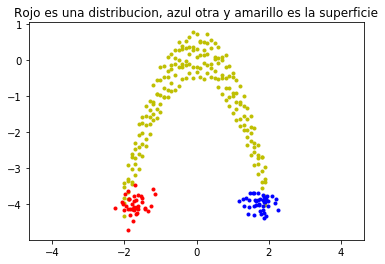

In [536]:
puntos=40

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1)
W=np.concatenate((x,y),axis=1)


dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)




y1, y2 = np.random.multivariate_normal([1.7,-4], [[0.05,0],[0,0.05]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-1.7,-4], [[0.05,0],[0,0.05]], puntos).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()





plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.show()

In [537]:
data=np.concatenate((Zcol,Ycol,W),axis=0)

samples=np.concatenate((Zcol,Ycol),axis=0) #los datos X iniciales, las distribuciones.
z=np.matrix([0 for i in range(Zcol.shape[0])]+[1 for i in range(Ycol.shape[0])]).T
#le pongo label 0 a la primera y 1 a la segunda

alpha=2
k=5
dimension=2
f_dist,tree=fermat_graph(data,alpha=alpha)

def my_fermat_cost(x,initialData):
    return fermat_cost_cuad_fast(x,initialData,dimension,f_dist,tree,data,k,alpha)

llamo al baricentro

In [556]:
n_iter=300
learningrate0=1
landa0=5
landamax=1e6
beta_adapt=0.05


h=np.std(samples)*1.06*(samples.shape[0]**(-1/5))
h=-1 #Esto hace que el h se adapte a cada paso (con la formula de arriba pero con los y actuales, no fijado con los y_iniciales)!

#cost_function=euclidean_cost
cost_function=my_fermat_cost

yinit=samples
    
bari=barycenter(yinit,n_iter,samples,landa0,landamax,learningrate0,z,h,beta_adapt,cost_function)

it: 0, paso: 0.9123877134941794, landa: 5
it: 1, paso: 1.0089284899721045, landa: 5
it: 2, paso: 0.7437353661035124, landa: 5
it: 3, paso: 0.5036648485287909, landa: 5
it: 4, paso: 0.4409560518068961, landa: 5
it: 5, paso: 0.3716398461911685, landa: 5
it: 6, paso: 0.3613289841154788, landa: 5
it: 7, paso: 0.27488392851374255, landa: 5
it: 8, paso: 0.2612438530084799, landa: 5
it: 9, paso: 0.26011750668128597, landa: 5
it: 10, paso: 0.21981146350218714, landa: 5.069764986200919
it: 11, paso: 0.20841312217752303, landa: 5.211827527756349
it: 12, paso: 0.12971658628553798, landa: 5.453053571444394
it: 13, paso: 0.14797101793123618, landa: 5.746495198074578
it: 14, paso: 0.14671733436763296, landa: 6.056637833800126
it: 15, paso: 0.18450994431641946, landa: 6.330501447620396
it: 16, paso: 0.14021484799885825, landa: 6.6900870139815005
it: 17, paso: 0.18721924736361426, landa: 7.068294823075067
it: 18, paso: 0.1289256850513021, landa: 7.553566441805449
it: 19, paso: 0.11513833975672476, lan

it: 140, paso: 0.023104939041497623, landa: 3306.3214281293863
it: 141, paso: 0.032908317067679965, landa: 3373.935283439173
it: 142, paso: 0.06001449581578522, landa: 3423.12750178276
it: 143, paso: 0.12325059443754433, landa: 3513.7620967173216
it: 144, paso: 0.07866895904231727, landa: 3632.1365873792415
it: 145, paso: 0.023810733948284243, landa: 3632.1365873792415
it: 146, paso: 0.03443389193755993, landa: 3635.5442074691
it: 147, paso: 0.06639134189136416, landa: 3680.242135629555
it: 148, paso: 0.13567638149882716, landa: 3763.0814242764736
it: 149, paso: 0.09107816760678429, landa: 3777.0317244822813
it: 150, paso: 0.03359688703958887, landa: 3777.0317244822813
it: 151, paso: 0.03642970370507411, landa: 3777.0317244822813
it: 152, paso: 0.06699034271021587, landa: 3841.2098067315274
it: 153, paso: 0.07400678054772185, landa: 3925.5413892575934
it: 154, paso: 0.08863344983607813, landa: 3925.5413892575934
it: 155, paso: 0.033893243230606836, landa: 3925.5413892575934
it: 156, pa

it: 274, paso: 0.015777792355436904, landa: 17614.620891164097
it: 275, paso: 0.01566145589952528, landa: 17614.620891164097
it: 276, paso: 0.03104922754386413, landa: 17614.620891164097
it: 277, paso: 0.03377662347919295, landa: 17614.620891164097
it: 278, paso: 0.011732760901977998, landa: 17614.620891164097
it: 279, paso: 0.015649663704441905, landa: 17614.620891164097
it: 280, paso: 0.03132137314867659, landa: 17614.620891164097
it: 281, paso: 0.06479380081491207, landa: 17614.620891164097
it: 282, paso: 0.015248911978454545, landa: 17614.620891164097
it: 283, paso: 0.01599336831610579, landa: 17614.620891164097
it: 284, paso: 0.031972284568198055, landa: 17614.620891164097
it: 285, paso: 0.06768210851785636, landa: 17614.620891164097
it: 286, paso: 0.019840237108768668, landa: 17614.620891164097
it: 287, paso: 0.016666292533626458, landa: 17614.620891164097
it: 288, paso: 0.033309315963971256, landa: 17614.620891164097
it: 289, paso: 0.03614939733293878, landa: 17614.620891164097


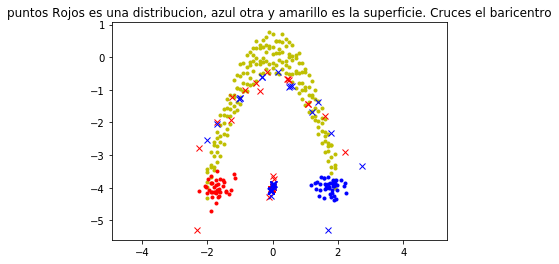

In [557]:
if cost_function==my_fermat_cost:
    plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(bari[:puntos,0],bari[:puntos,1],'x',c='r')
plt.plot(bari[puntos:,0],bari[puntos:,1],'x',c='b')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()

-El h adaptativo achica mucho mas rapido la varianza!!

-Los puntos se empiezana expandir para mejorar al principio, como despues pasa que los que se alejan hacia afuera se vienen al baricentro? Por qué pasaria? h adaptativo parece ayudar a eso

-Cuan adaptativo elijo el beta (alpha del paper)? Cuan dependiente del caso e esto? hacer un adaptativo on 0.01 o 0.05 parece andar bien

-landa max??

-landa0, es muy relevante? Arranca igual si tomo uno muy chico.
